RANDOM LINEAR CLASSIFIER ON TEST DATA

In [10]:
## importing the libraries; numpy(scientific computing) and matplotlib(for plotting)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

In [11]:
np.random.seed(0) ## Makes random generation predictable.

In [12]:
# here normal --> Normal Gaussian distribution. Loc is basically the mean so the whisker length is centered around 5. Scale 1 means that
# all the values will be between 4 and 6, size is basically the size of the array. 
# Eg: for flappiness: array([8.21, 7.95, 9.10, 7.32, 8.75, 8.12, 6.89, 7.58, 8.66, 7.44])

dogs_whisker_length = np.random.normal(loc=5, scale=1, size=10)
dogs_ear_flappines_index = np.random.normal(loc=8, scale=1, size=10)

In [13]:

cats_whisker_length = np.random.normal(loc=8, scale=1, size=10)
cats_ear_flappines_index = np.random.normal(loc=5, scale=1, size=10)

In [24]:
dogs_data = np.vstack((dogs_whisker_length, dogs_ear_flappines_index)).T
cats_data = np.vstack((cats_whisker_length, cats_ear_flappines_index)).T
data = np.vstack((dogs_data, cats_data))
labels = np.hstack((np.zeros(len(cats_data)), np.ones(len(dogs_data))))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [26]:
y_train

array([0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.])

/var/folders/4d/s4myz09n61x3tlr4qf0r85qw0000gn/T/ipykernel_6367/499015980.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_test[:, 0], X_test[:, 1], label = 'Test samples', cmap='bwr')


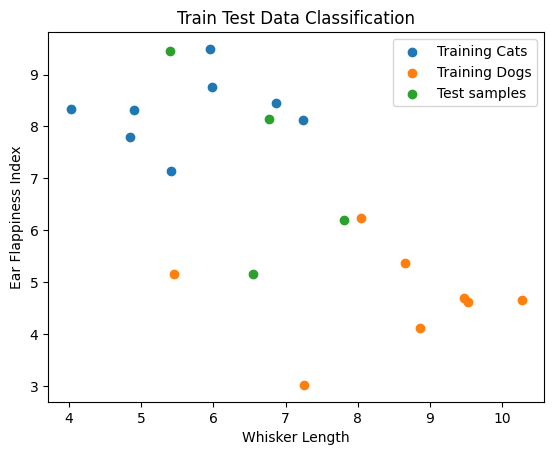

In [31]:
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label = 'Training Cats')
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label = 'Training Dogs')
plt.scatter(X_test[:, 0], X_test[:, 1], label = 'Test samples', cmap='bwr')
plt.xlabel("Whisker Length")
plt.ylabel("Ear Flappiness Index")
plt.title("Train Test Data Classification")
plt.legend()
plt.show()

In [32]:
# Implementing random linear classifier algo

# 1) Take random values of theta and theta0 in every iteration of K.
# 2) For each iteration calculate the error by doing theta0 + theta(transpose)X 
# 3) If its greator than 0 then +1 and <0 then -1
# For dogs the value should be +1 and for cats it should be -1 if its otherwise we add it to the error

In [33]:
def calculate_error(dogs, cats, theta0, theta):
    error = 0
    for dog_sample in dogs:
        # Here Shape of theta is 1*2 and Shape of dog_sample is 2*1 so final is a scalar
        if(np.dot(theta, dog_sample) + theta0 <= 0):
            error +=1

    for cat_sample in cats:
        if(np.dot(theta, cat_sample) + theta0 > 0):
            error +=1
    
    return error

In [34]:
def random_linear_classifier(data_dogs, data_cats, k, d): # here d is the number of dimensions which is 2 in this case

    min_error = float('inf')
    final_theta0 = None    
    final_theta = None   

    for _ in range(k):
        theta0 = np.random.normal()
        theta = np.random.normal(size=d)

        local_error = calculate_error(data_dogs, data_cats, theta0, theta)

        if(local_error < min_error):
            min_error = local_error
            final_theta = theta
            final_theta0 = theta0

    return final_theta0, final_theta


In [41]:
best_theta0_train, best_theta_train = random_linear_classifier(X_train[y_train == 1], X_train[y_train == 0], k=100, d=2)

In [42]:
best_theta0_train, best_theta_train

(0.8145198224878663, array([ 0.05892559, -0.18505367]))

In [45]:
# Linspace is used to create 100 values between 2 and 10
x_vals_train = np.linspace(2,10,100)
# ax+by+c = 0 ---> y = (-c-ax)/b
y_vals_train = (-best_theta0_train/best_theta_train[1]) - (best_theta_train[0]/best_theta_train[1]) * x_vals

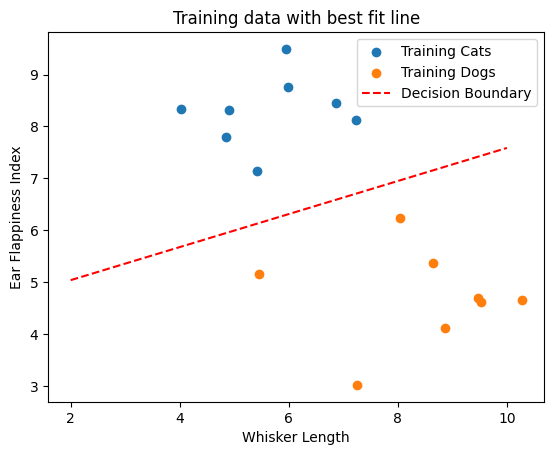

In [46]:
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label = 'Training Cats')
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label = 'Training Dogs')
plt.plot(x_vals_train, y_vals_train, color="red", linestyle = '--', label = "Decision Boundary")
plt.xlabel("Whisker Length")
plt.ylabel("Ear Flappiness Index")
plt.title("Training data with best fit line")
plt.legend()
plt.show()

In [47]:
test_error = calculate_error(X_test[y_test == 1], X_test[y_test == 0], best_theta0_train, best_theta_train)
test_error

0

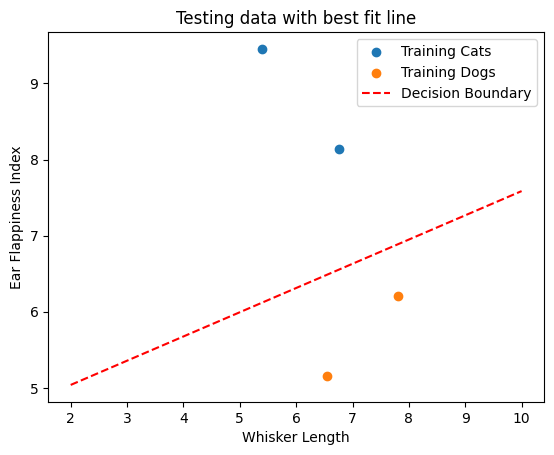

In [48]:
plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], label = 'Training Cats')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], label = 'Training Dogs')
plt.plot(x_vals_train, y_vals_train, color="red", linestyle = '--', label = "Decision Boundary")
plt.xlabel("Whisker Length")
plt.ylabel("Ear Flappiness Index")
plt.title("Testing data with best fit line")
plt.legend()
plt.show()

In [54]:
## Coding cross validation error to find the most optimal value of K to test the algorithm.
# 1) Here for each K we calculate the error for each fold which is there.
# 2) We take the average of all the error and store in an error for that K
# 3) Once that is done we move to the next K value and repeat the entire process.
# 4) Out of all the K's the one which has the least value of avg error is chosen.

def cross_validation_error(dogs_data, cats_data, k_values, d, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    avg_errors = []

    for k in k_values:
        errors = []

        for train_index, val_index in kf.split(dogs_data):
            X_train_fold = np.vstack((dogs_data[train_index], cats_data[train_index]))
            y_train_fold = np.hstack((np.ones(len(train_index)), np.zeros(len(train_index))))
            X_test_fold = np.vstack((dogs_data[val_index], cats_data[val_index]))
            y_test_fold = np.hstack((np.ones(len(val_index)), np.zeros(len(val_index))))
            
            final_theta0, final_theta = random_linear_classifier(X_train_fold[y_train_fold == 1], X_train_fold[y_train_fold == 0], k, d)
            
            errors.append(calculate_error(X_test_fold[y_test_fold == 1], X_test_fold[y_test_fold == 0], final_theta0, final_theta))

        avg_errors.append(np.mean(errors))

    print(avg_errors)
    best_k = k_values[np.argmin(avg_errors)]
    return best_k

    
k_values = [1,5,50,100,200,350]
            

best_k = cross_validation_error(dogs_data, cats_data, k_values, d=2)


[np.float64(2.2), np.float64(1.6), np.float64(0.8), np.float64(0.2), np.float64(0.2), np.float64(0.2)]


In [55]:
best_k

100